#### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
data = pd.read_excel('kurs_jisdor.xlsx')
data.head()

,Tanggal,Kurs
0,2023-06-09,14853
1,2023-06-08,14903
2,2023-06-07,14875
3,2023-06-06,14839
4,2023-06-05,14888


In [3]:
print(data.isnull().sum())

Tanggal    0
Kurs       0
dtype: int64


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tanggal  2446 non-null   object
 1   Kurs     2446 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.3+ KB


Melakukan analisis deskriptif untuk lebih mengenal distribusi dari semua variabel di dalam data.

In [5]:
# Menampilkan statistik deskriptif dari kolom kurs
print("Statistik Deskriptif Kurs:")
print(data['Kurs'].describe())
print()

Statistik Deskriptif Kurs:
count     2446.000000
mean     13669.278823
std       1190.081242
min       9760.000000
25%      13218.500000
50%      13946.500000
75%      14413.000000
max      16741.000000
Name: Kurs, dtype: float64



In [6]:
print(data)

         Tanggal   Kurs
0     2023-06-09  14853
1     2023-06-08  14903
2     2023-06-07  14875
3     2023-06-06  14839
4     2023-06-05  14888
...          ...    ...
2441  2013-05-24   9772
2442  2013-05-23   9774
2443  2013-05-22   9765
2444  2013-05-21   9765
2445  2013-05-20   9760

[2446 rows x 2 columns]


Sekarang mari tambahkan kolom tahun dan bulan di data sebelum melanjutkan.

In [7]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%Y-%m-%d')
data = data.sort_values('Tanggal') # Untuk mengurutkan data berdasarkan tanggal supaya monotonik agar proses indexing dan analisi time series berjalan lancar

data['Tahun'] = data['Tanggal'].dt.year
data['Bulan'] = data['Tanggal'].dt.month
print(data.head())

        Tanggal  Kurs  Tahun  Bulan
2445 2013-05-20  9760   2013      5
2444 2013-05-21  9765   2013      5
2443 2013-05-22  9765   2013      5
2442 2013-05-23  9774   2013      5
2441 2013-05-24  9772   2013      5


Sekarang mari kita lihat pertumbuhan tahunan kurs IDR-USD

In [8]:
import plotly.graph_objs as go
import plotly.io as pio

# Menghitung dan menampilkan distribusi pertumbuhan tahunan kurs
growth = data.groupby('Tahun').agg({'Kurs': lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]*100})

fig = go.Figure()
fig.add_trace(go.Bar(x=growth.index,
                     y=growth['Kurs'],
                     name='Pertumbuhan Tahunan Kurs'))

fig.update_layout(title="Pertumbuhan Tahunan Kurs IDR - USD",
                  xaxis_title="Tahun",
                  yaxis_title="Pertumbuhan (%)",
                  width=900,
                  height=600)

pio.show(fig)

Sekarang mari kita lihat pertumbuhan gabungan bulanan dari rasio kurs jual antara IDR dan USD, dimana variabel ini sangat berdampak langsung pada nasabah.

In [9]:
# Calculate monthly growth
data['Pertumbuhan'] = data.groupby(['Tahun', 'Bulan'])['Kurs'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Group data by Month and calculate average growth
grouped_data = data.groupby('Bulan').mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=grouped_data['Bulan'],
    y=grouped_data['Pertumbuhan'],
    marker_color=grouped_data['Pertumbuhan'],
    hovertemplate='Bulan: %{x}<br>Rata-rata pertumbuhan: %{y:.2f}%<extra></extra>'
))

fig.update_layout(
    title='Pertumbuhan Bulanan Gabungan Tingkat Kurs IDR - USD',
    xaxis_title='Bulan',
    yaxis_title='Rata-rata Pertumbuhan (%)',
    width=900,
    height=600
)

pio.show(fig)

Pada grafik di atas terlihat bahwa nilai konversi mengalami penurunan di bulan Februari dan Maret, mengalami kenaikan pada bulan April, sebelum akhirnya mengalami penurunan selama 5 bulan berikutnya. Oktober sempat mengalami kenaikan sebelum akhirnya turun kembali hingga bulan ke-12

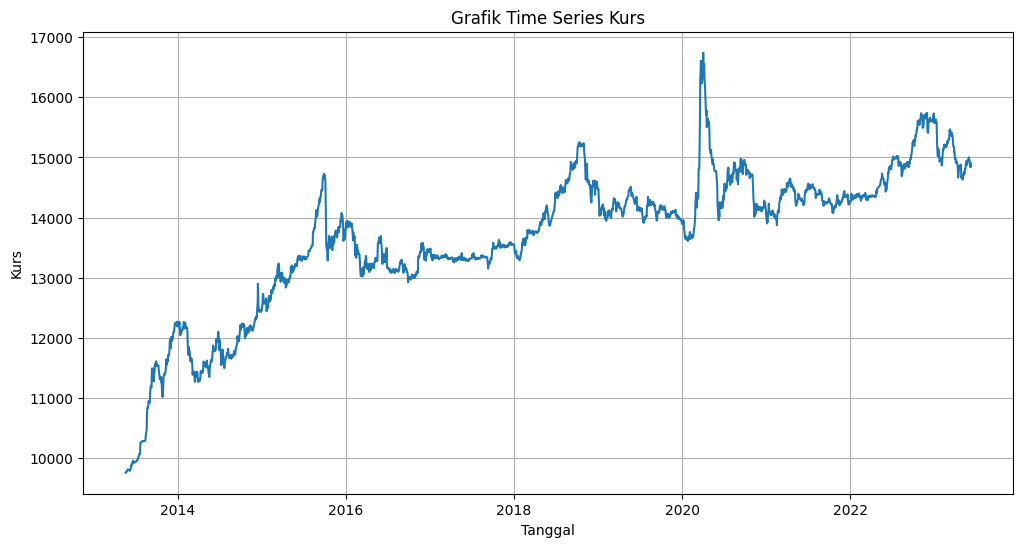

In [46]:
# Visualization of time series for selling rates
plt.figure(figsize=(12, 6))
plt.plot(data['Kurs'])
plt.title('Grafik Time Series Kurs')
plt.xlabel('Tanggal')
plt.ylabel('Kurs')
plt.grid(True)
plt.show()

#### Mengembangkan Pemodelan Forecasting

Sebelumnya kita akan melihat exchange rates menggunakan time series analysis. Kita perlu melakukan seasonal_decompose, yang akan membantu kita mengidentifikasi pola berulang, tren jangka panjang, dan fluktuasi acak yang ada dalam data nilai tukar IDR - USD:

<Figure size 640x480 with 0 Axes>

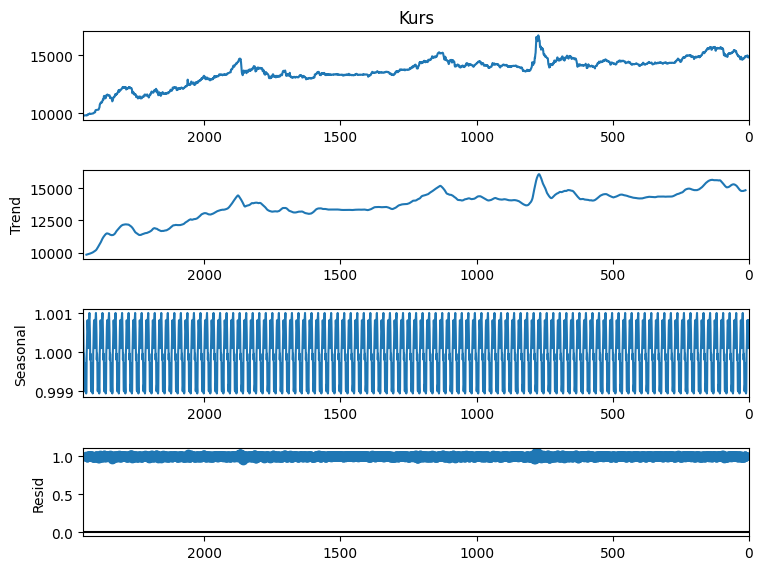

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Kurs'], model='multiplicative', period=24)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)
fig.show()

Seperti yang kita lihat bahwa ada pola musiman dalam data ini, kita perlu melakukan teknik yang tepat untuk melakukan peramalan. Jadi, SARIMA akan menjadi algoritma yang paling tepat untuk data ini. Sebelum menggunakan SARIMA, kita perlu mencari nilai p,d, dan q.

In [11]:
# Mengubah kolom 'Tanggal' menjadi index datetime
# Memisahkan data menjadi training set dan test set
data.set_index('Tanggal', inplace=True)

train_data = data['2013-01-01':'2020-12-31']
test_data = data['2021-01-01':]

train_data.index = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='D')
test_data.index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='D')

In [12]:
data.head()

,Kurs,Tahun,Bulan,Pertumbuhan
Tanggal,,,,
2013-05-20,9760,2013,5,0.430328
2013-05-21,9765,2013,5,0.430328
2013-05-22,9765,2013,5,0.430328
2013-05-23,9774,2013,5,0.430328
2013-05-24,9772,2013,5,0.430328


In [13]:
# Melakukan differencing untuk menghilangkan tren atau pola yang dapat menyebabkan data menjadi non-stasioner.
train_data_diff = train_data.diff().dropna()

In [35]:
import pmdarima as pm

# Mencari parameter p, d, q dengan menggunakan fungsi auto_arima
#model = pm.auto_arima(train_data['Kurs'], seasonal=False, suppress_warnings=True)
model = pm.auto_arima(train_data['Kurs'], seasonal=True, m=52, suppress_warnings=True)
print(model.order)

# Menampilkan parameter yang terbaik
#print("Parameter terbaik: ", model.order)

(2, 1, 1)


In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import statsmodels.api as sm

# Membangun model ARIMA dengan parameter terbaik
model = SARIMAX(train_data['Kurs'], order=(2, 1, 1), 
                seasonal_order=(2, 1, 1, 52))  
model_fit = model.fit() 
print(model_fit.summary())

#model = sm.tsa.ARIMA(train_data['Kurs'], order=(2, 1, 1))
#model_fit = model.fit()

# Menampilkan summary pemodelan
#print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Kurs   No. Observations:                 1850
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 52)   Log Likelihood              -10122.707
Date:                            Sun, 11 Jun 2023   AIC                          20259.414
Time:                                    13:39:54   BIC                          20297.871
Sample:                                05-20-2013   HQIC                         20273.611
                                     - 06-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9356      0.066     14.227      0.000       0.807       1.065
ar.L2         -0.0728      0.020   

Model ARIMA yang dibangun memiliki nilai log likelihood yang tinggi, menunjukkan bahwa model tersebut dapat menjelaskan variasi dalam data dengan baik. Koefisien model memiliki nilai p-value yang rendah, menunjukkan bahwa mereka secara signifikan berkontribusi dalam model.

Namun begitu, Residual dalam model tidak terdistribusi secara normal, seperti yang ditunjukkan oleh uji Jarque-Bera. Ini menunjukkan adanya ketidaksesuaian antara asumsi model dengan data aktual.

In [48]:
# Melakukan prediksi menggunakan model yang telah dilatih
forecast = model_fit.forecast(steps=len(test_data))
#predictions = model_fit.predict(len(test_data), len(test_data)+60)
#print(predictions)

# Menampilkan hasil forecasting
print(forecast)

2018-06-13    14086.464757
2018-06-14    14081.836666
2018-06-15    14068.866941
2018-06-16    14071.748240
2018-06-17    14066.032719
                  ...     
2020-01-25    15458.811958
2020-01-26    15467.548811
2020-01-27    15485.485433
2020-01-28    15510.585267
2020-01-29    15529.652686
Freq: D, Name: predicted_mean, Length: 596, dtype: float64


In [43]:
# Create figure
fig = go.Figure()

# Add training data line plot
fig.add_trace(go.Scatter(
    x=train_data.index,
    y=train_data['Kurs'],
    mode='lines',
    name='Training Data',
    line=dict(color='blue')
))

# Add forecasting line plot
fig.add_trace(go.Scatter(
    x=forecast.index,
    y=forecast,
    mode='lines',
    name='Forecasting',
    line=dict(color='#FCAE1E')
))

fig.update_layout(
    title="Nilai Rupiah - Data Pelatihan dan Peramalan",
    xaxis_title="Tanggal",
    yaxis_title="Kurs",
    legend_title="Data",
    width=900,
    height=600
)

pio.show(fig)

Berdasarkan hasil peramalan yang Anda sampaikan, terlihat bahwa nilai peramalan meningkat secara konsisten dari Juni 2018 hingga Januari 2022. Grafik time series juga menunjukkan tren naik yang sama selama periode tersebut.

Ada beberapa hal yang perlu diperhatikan agar peramalan ini dapat diandalkan, yakni salah satunya dengan menguji Kepercayaan Peramalan yang tujuannya apakah pemodelan memberikan interval kepercayaan yang sesuai.

#### **Kesimpulan**

Peramalan nilai tukar mata uang berarti memprediksi fluktuasi masa depan dalam nilai satu mata uang terhadap mata uang lainnya. Ini melibatkan penggunaan data historis, indikator ekonomi, dan model matematika untuk membuat prediksi yang akurat tentang arah dan besarnya pergerakan nilai tukar.

Pemodelan yang telah kami buat menunjukkan peramalan yang cukup, namun begitu bukan berarti pemodelan ini tidak ada batasan. Atas hal tersebut, diperlukan pengujian lebih lanjut untuk mengoptimalkan hasil peramalan. Seperti pengujian interval kepercayaan, penyesuaian model dan parameter, serta konteks domain, dalam hal ini adalah melibatkan beberapa faktor seperti kondisi ekonomi, kebijakan moneter, faktor geopolitik, dan peristiwa dunia, dimana faktor-faktor tersebut erat kaitannya dengan perubahan nilai tukar mata uang.